In [1]:
import numpy as np
import pandas as pd

numerical = ['Fare', 'Age', 'TicketNumber']
categorical = ['Embarked', 'Title', 'Pclass']
dum_categorical = []
target = 'Perished'

objectives = {
    'LGB': None,
    'RF': None,
    'CAT': None,
    'LR': None,
}

def preprocess(path_train, path_test, is_dummies=False):
    train = pd.read_csv(path_train)
    test = pd.read_csv(path_test)
    target = train['Perished']
    df = pd.concat([train.drop('Perished', axis=1), test], axis=0)

    df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev', 'Don', 'Sir', 'Jonkheer'], 'Mr')
    df['Title'] = df['Title'].replace(['Mme', 'Ms', 'Lady', 'the Countess', 'Dona'], 'Mrs')
    df['Title'] = df['Title'].replace(['Mlle'], 'Miss')
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    df.loc[df['Sex'] != 'male', 'Age'] *= -1
    #df['Age'] = df['Age'].where(df['Age']>=1, 0)
    #df['Deck'] = df['Cabin'].isnull().astype(object) ##注意
    #df['()'] = df['Name'].str.contains(r'\(.*\)')
    #df['Family'] = df['SibSp'] + df['Parch'] + 1
    df['TicketNumber'] = df['Ticket'].map(df['Ticket'].value_counts())
    
    
    #for col in categorical: df[col] = df[col].where(df[col].map(df[col].value_counts()) > 10)
    dummies = pd.get_dummies(df[categorical], columns=categorical, drop_first=True)
    dum_categorical.extend(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    
    df[numerical] = df[numerical].fillna(df[numerical].median())
    df[categorical] = df[categorical].astype('category')
    df[['Fare', 'TicketNumber']] = np.log1p(df[['Fare', 'TicketNumber']])

    df_train = pd.concat([df.iloc[:len(train)], target], axis=1)
    df_test = df.iloc[len(train):]
    return df_train, df_test

df_train, df_test = preprocess("../data/train.csv", "../data/test.csv")
df_train['Title'].value_counts()

Title
Mr        538
Miss      184
Mrs       129
Master     40
Name: count, dtype: int64

In [2]:
df_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'TicketNumber',
       'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Pclass_2', 'Pclass_3', 'Perished'],
      dtype='object')

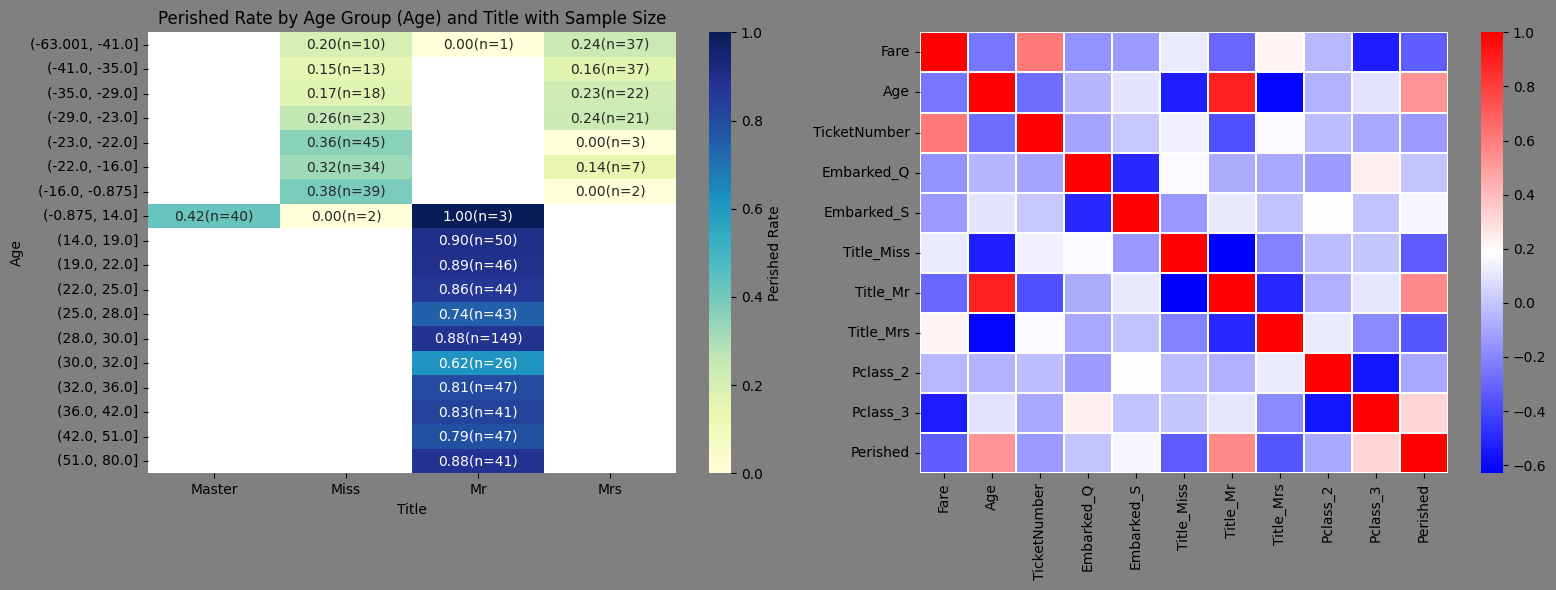

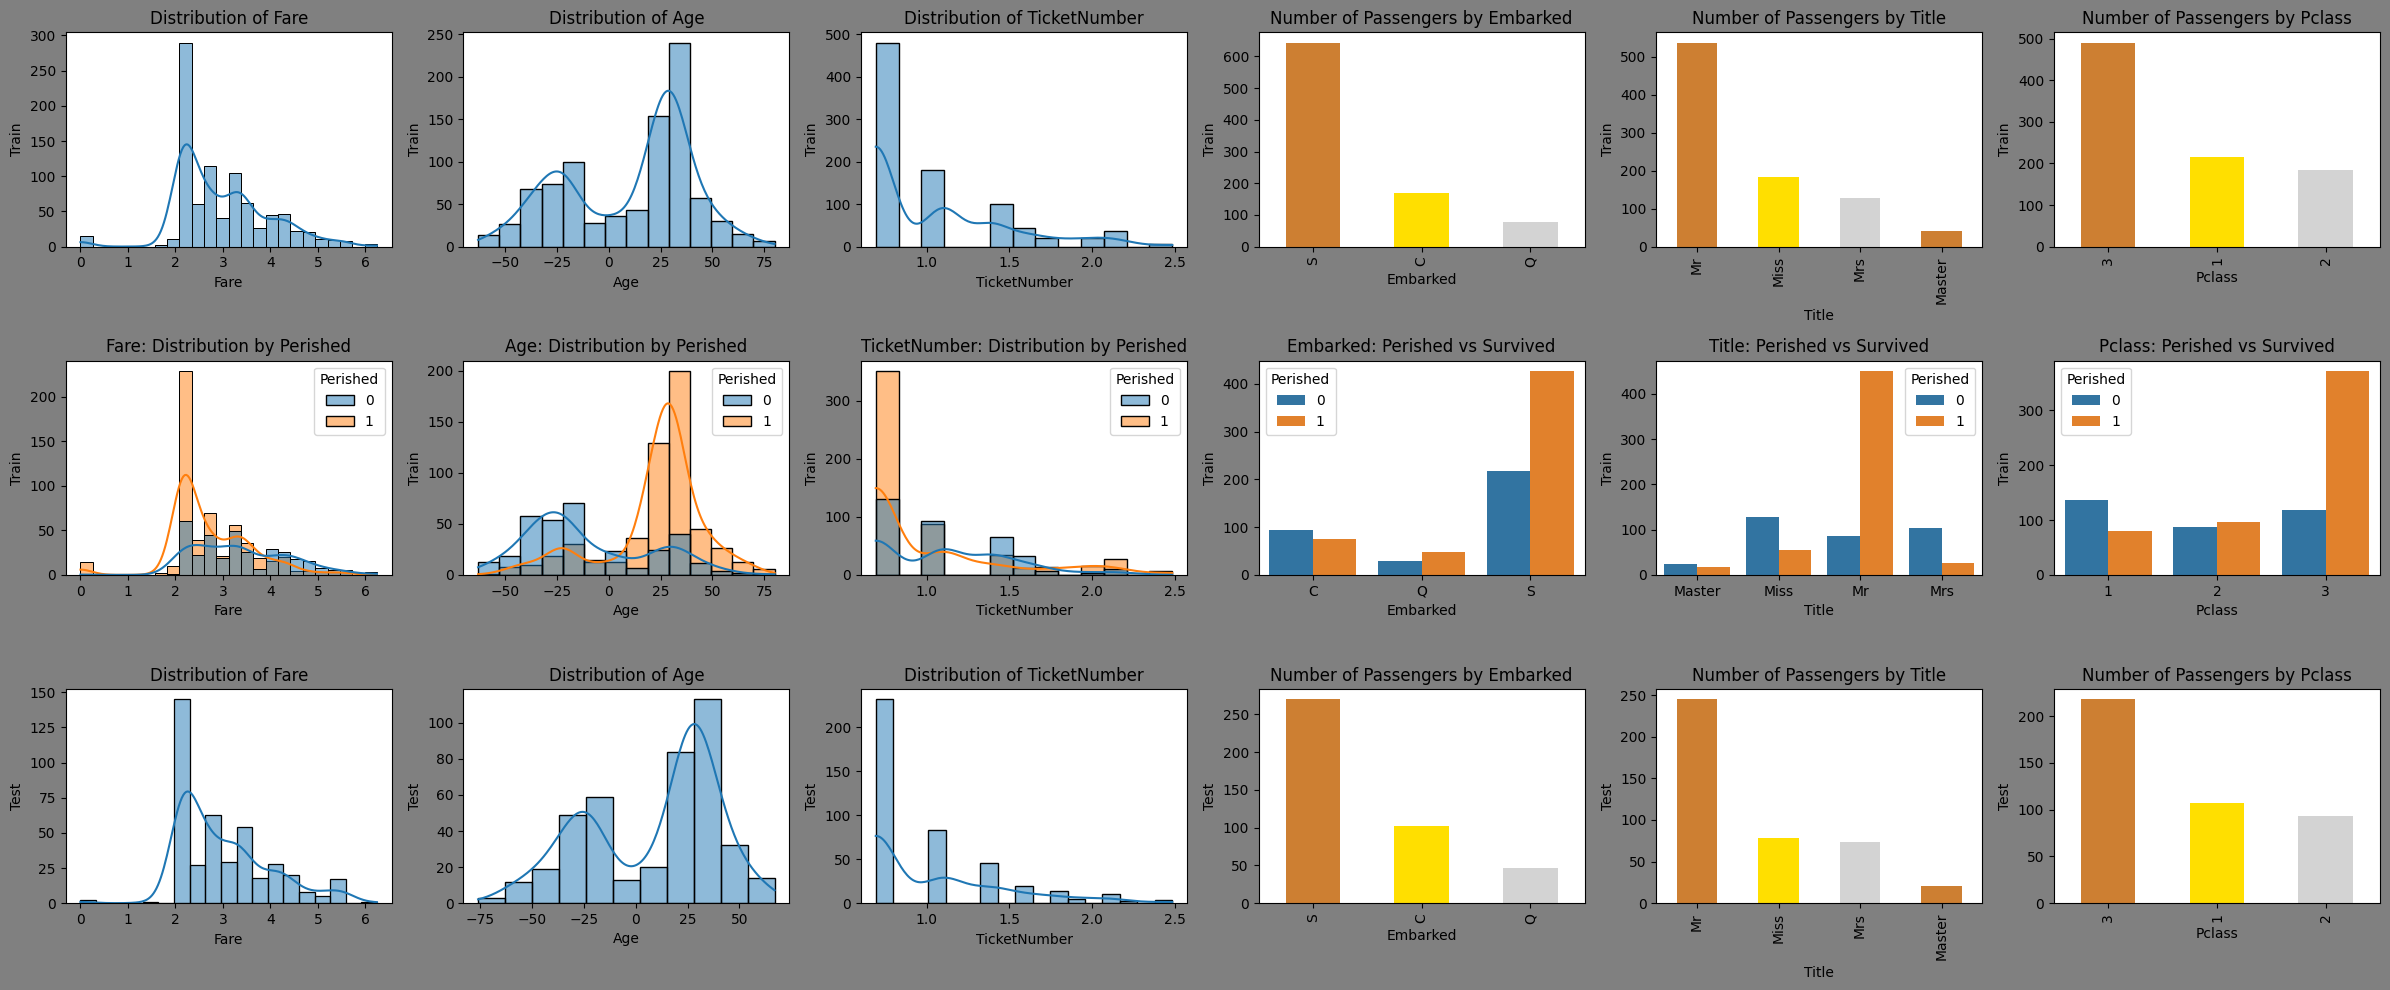

In [3]:
from target_rate import target_rate
target_rate(df_train, df_test, numerical_feature='Age', boolean_feature='Title', target=target, numerical=numerical, categorical=categorical, dum_categorical=dum_categorical, q=True, n=20, is_annot=False)

In [4]:
from objective import Objective
from models import LGB, RF, CAT, LR
from params import lgb_params, rf_params, cat_params, lr_params
from sklearn.model_selection import train_test_split

X = df_train[numerical+categorical+dum_categorical]
y = df_train[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for key in objectives:
    print(key)
    if key=='LGB': objectives[key]=Objective(X, y, model=LGB, params=lgb_params, numerical=numerical, categorical=categorical, n_trial=300)
    if key=='RF': objectives[key]=Objective(X, y, model=RF, params=rf_params, numerical=numerical, categorical=dum_categorical, n_trial=100)
    if key=='CAT': objectives[key]=Objective(X, y, model=CAT, params=cat_params, numerical=numerical, categorical=categorical, n_trial=300)
    if key=='LR': objectives[key]=Objective(X, y, model=LR, params=lr_params, numerical=numerical, categorical=dum_categorical, n_trial=100)
    objectives[key]()

LGB


  0%|          | 0/300 [00:00<?, ?it/s]

RF


  0%|          | 0/100 [00:00<?, ?it/s]

CAT


  0%|          | 0/300 [00:00<?, ?it/s]

LR


  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# 最適なハイパーパラメータの表示
print("Best trial:")
for key in objectives:
    print(f'{key}: {objectives[key].study.best_trial.params}')

Best trial:
LGB: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.08630307340106586, 'feature_fraction': 0.7381470298439288, 'bagging_fraction': 0.7269831922468342, 'bagging_freq': 10, 'lambda_l1': 0.9112008497422085, 'lambda_l2': 0.22435161273607224, 'min_data_in_leaf': 30, 'n_iterations': 78}
RF: {'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 22, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'bootstrap': False}
CAT: {'depth': 4, 'learning_rate': 0.051059032093947576, 'l2_leaf_reg': 10.411689885916049, 'iterations': 196}
LR: {'penalty': 'elasticnet', 'C': 0.1984008166726199, 'max_iter': 9214, 'l1_ratio': 0.25240026156336703}


LGB Accuracy: 0.8061797752808989 , Best Score: [0.75, 0.7777777777777778, 0.8309859154929577, 0.8450704225352113, 0.8028169014084507, 0.7887323943661971, 0.7746478873239436, 0.8450704225352113, 0.8450704225352113, 0.8028169014084507]
RF Accuracy: 0.8384831460674157 , Best Score: [0.7777777777777778, 0.8055555555555556, 0.8873239436619719, 0.8591549295774648, 0.8732394366197183, 0.8309859154929577, 0.7746478873239436, 0.8450704225352113, 0.9014084507042254, 0.8309859154929577]
CAT Accuracy: 0.8216292134831461 , Best Score: [0.7638888888888888, 0.8055555555555556, 0.8873239436619719, 0.8591549295774648, 0.8309859154929577, 0.8732394366197183, 0.7746478873239436, 0.8309859154929577, 0.8169014084507042, 0.7746478873239436]
LR Accuracy: 0.8089887640449438 , Best Score: [0.7638888888888888, 0.7916666666666666, 0.8732394366197183, 0.8309859154929577, 0.8591549295774648, 0.8169014084507042, 0.7605633802816901, 0.8028169014084507, 0.7887323943661971, 0.8028169014084507]


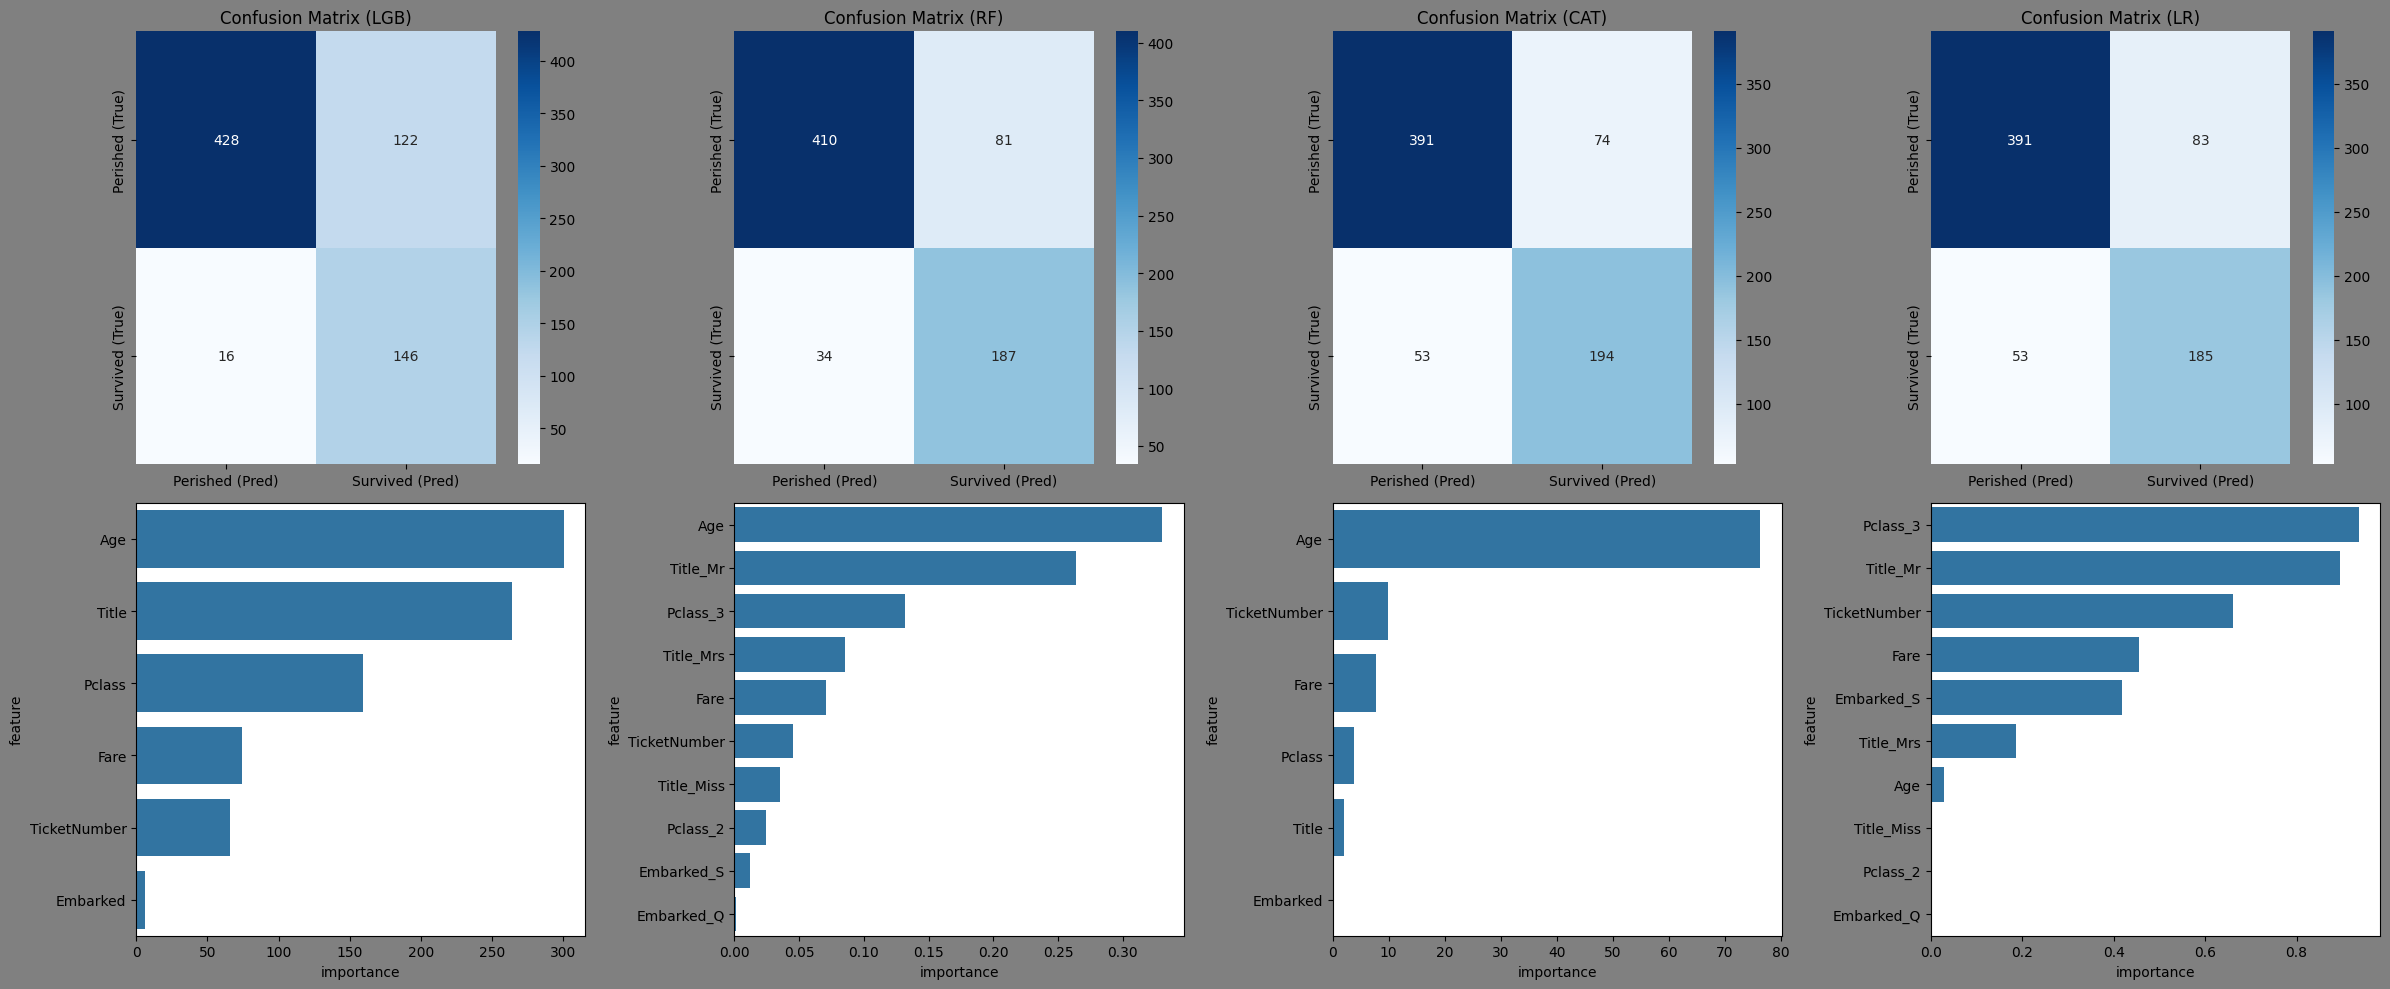

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

f, ax = plt.subplots(2, len(objectives), figsize=(6*len(objectives), 10), facecolor='gray')
i = 0
for key in objectives:
    pred_prob = []
    feature_importances = []
    for model in objectives[key].best_model:
        pred_prob.append(model.predict(X_test))
        feature_importances.append(model.feature_importance())
    #print("Accuracy:", accuracy_score(y_test, (np.mean(pred_prob, axis=0) > 0.5).astype(int)))
    print(f"{key} Accuracy:", accuracy_score(objectives[key].best_y_valid, (objectives[key].best_y_pred > 0.5).astype(int)), ", Best Score:", objectives[key].best_score)
    feature_importance = pd.concat(feature_importances)
    feature_importance = feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
    tn, fp, fn, tp = confusion_matrix(objectives[key].best_y_valid, (objectives[key].best_y_pred > 0.5).astype(int)).ravel()
    
    df_conf = pd.DataFrame(
        [[tp, fp],
         [fn, tn]],
        index=["Perished (True)", "Survived (True)"],
        columns=["Perished (Pred)", "Survived (Pred)"]
    )
    
    sns.heatmap(df_conf, annot=True, fmt='d', cmap='Blues', ax=ax[0, i])
    ax[0, i].set_title(f"Confusion Matrix ({key})")
    
    sns.barplot(feature_importance, x='importance', y='feature', ax=ax[1, i])
    i += 1
plt.tight_layout()
plt.show()
    

In [7]:
pred = (np.mean([model.predict(df_test[numerical+categorical+dum_categorical]) for model in objectives[key].best_model for key in objectives], axis=0) > 0.5).astype(int)
print(f'Perished rate: {np.count_nonzero(pred==1)/len(pred)}')
submission = pd.read_csv('../gender_submission.csv')
submission[target] = pred
submission

Perished rate: 0.645933014354067


,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [8]:
submission.to_csv('../submission.csv',index=False)